In [43]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imutils import paths
from keras.models import Sequential
from keras.applications.xception import Xception
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import argparse
import imutils
import ntpath
import cv2
import os

import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

import pandas as pd

from keras.optimizers import Adam, Nadam, Adadelta
from keras.activations import relu, elu
from keras.losses import categorical_crossentropy

%matplotlib inline

log_device_placement = True

In [2]:
cd /home/carlywolfbrandt/galvanize/assignments/csk_image_recognition/images/initial_dataset/

/home/carlywolfbrandt/galvanize/assignments/csk_image_recognition/images/initial_dataset


In [88]:
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rescale=1. / 255,
        horizontal_flip=False,
        fill_mode='nearest')

for subdir, dirs, files in os.walk('/home/carlywolfbrandt/galvanize/assignments/csk_image_recognition/images/initial_dataset/train'):
    for dr in dirs:
        i = 0
        img = load_img(f'train/{dr}/{dr}.png')
        x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
        for batch in datagen.flow(x, batch_size=10,
                              save_to_dir=f'train/{dr}/', save_format='png'):
            i += 1
            print(i)
            if i > 100:
#                 print('stop')
                break 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
4

In [57]:
# dimensions of our images.
img_width, img_height = 150, 150


train_data_dir = 'train_3'
validation_data_dir = 'validation_3'
nb_train_samples = 3
nb_validation_samples = 3
epochs = 100
batch_size = 2
nb_filters = 32
extra_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)
act = 'relu'
opt = Adam(lr=0.001, decay=1e-6)


if K.image_data_format() == 'channels_first':
    input_shape = (3 , img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(nb_filters, kernel_size, input_shape=input_shape))
model.add(Activation(act))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(nb_filters + extra_filters, kernel_size))
model.add(Activation(act))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(nb_filters + extra_filters))
model.add(Activation(act))
model.add(Dropout(0.1))

model.add(Dense(1))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
               metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
    rescale=1. / 255,
#     shear_range=0.2,
#     zoom_range=0.2
)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# model = Xception(weights=None, input_shape=(img_height,img_width,3), classes=15)
# model.compile(loss='categorical_crossentropy',
#               optimizer='Adam',
#                metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

model.save_weights('model_6.h5')

Found 303 images belonging to 3 classes.
Found 3 images belonging to 3 classes.
Epoch 1/100


ValueError: Error when checking target: expected activation_68 to have shape (1,) but got array with shape (3,)

Found 1537 images belonging to 15 classes.
Found 15 images belonging to 15 classes.
Epoch 1/100
7/7 [==============================] - 2s 281ms/step - loss: 3.1585 - acc: 0.0714 - val_loss: 2.8216 - val_acc: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 2.7984 - acc: 0.1429 - val_loss: 2.8998 - val_acc: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 2.9238 - acc: 0.0714 - val_loss: 2.2016 - val_acc: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 3.1843 - acc: 0.0000e+00 - val_loss: 2.3802 - val_acc: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 2.7893 - acc: 0.2143 - val_loss: 2.4717 - val_acc: 0.0000e+00
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 2.7205 - acc: 0.1429 - val_loss: 2.9211 - val_acc: 0.0000e+00
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 2.8567 - acc: 0.0000e+00 - val_loss

Epoch 62/100
7/7 [==============================] - 0s 12ms/step - loss: 1.2857 - acc: 0.7143 - val_loss: 0.8229 - val_acc: 1.0000
Epoch 63/100
7/7 [==============================] - 0s 12ms/step - loss: 1.3761 - acc: 0.5714 - val_loss: 0.7141 - val_acc: 0.5000
Epoch 64/100
7/7 [==============================] - 0s 11ms/step - loss: 1.1726 - acc: 0.6429 - val_loss: 0.7076 - val_acc: 1.0000
Epoch 65/100
7/7 [==============================] - 0s 10ms/step - loss: 1.6267 - acc: 0.5000 - val_loss: 1.3691 - val_acc: 0.5000
Epoch 66/100
7/7 [==============================] - 0s 10ms/step - loss: 1.5009 - acc: 0.5714 - val_loss: 0.2274 - val_acc: 1.0000
Epoch 67/100
7/7 [==============================] - 0s 11ms/step - loss: 0.9641 - acc: 0.8571 - val_loss: 0.3080 - val_acc: 1.0000
Epoch 68/100
7/7 [==============================] - 0s 12ms/step - loss: 1.1745 - acc: 0.5714 - val_loss: 0.8923 - val_acc: 1.0000
Epoch 69/100
7/7 [==============================] - 0s 11ms/step - loss: 1.7292 - a

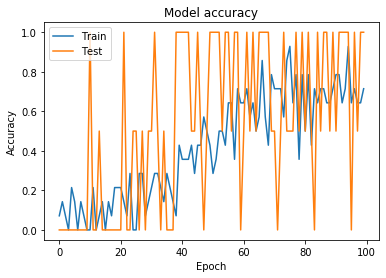

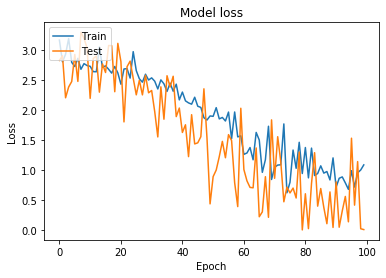

In [62]:
# dimensions of our images.
img_width, img_height = 150, 150


train_data_dir = 'train'
validation_data_dir = 'validation'
nb_train_samples = 15
nb_validation_samples = 15
epochs = 100
batch_size = 2
nb_filters = 32
extra_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)
act = 'elu'
opt = Adam(lr=0.0001, decay=1e-6)


if K.image_data_format() == 'channels_first':
    input_shape = (3 , img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(nb_filters, kernel_size, input_shape=input_shape))
model.add(Activation(act))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation(act))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(nb_filters + extra_filters, kernel_size))
model.add(Activation(act))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(nb_filters + extra_filters))
model.add(Activation(act))
model.add(Dropout(0.1))

model.add(Dense(nb_train_samples))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
               metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# model = Xception(weights=None, input_shape=(img_height,img_width,3), classes=15)
# model.compile(loss='categorical_crossentropy',
#               optimizer='Adam',
#                metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

model.save_weights('model_7.h5')

In [9]:
nb_train_samples

15

In [10]:
batch_size

10